# Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from scipy import optimize
from astropy.io import fits
import astropy.coordinates as coord
import pandas as pd
import os
from tabulate import tabulate
from jwst.residual_fringe.utils import fit_residual_fringes_1d as rf1d
import healpy as hp

# Parameters

In [2]:
t1 = 5  #truncation wvl 1
t2 = 27.8  #truncation wvl 2
arcsec_to_usr = 1e-4/4.25
fov1 =  3.2*3.7*arcsec_to_usr  #u*sr
fov2 =  4.0*4.8*arcsec_to_usr  #u*sr
fov3 =  5.2*6.2*arcsec_to_usr  #u*sr
fov4 =  6.6*7.7*arcsec_to_usr  #u*sr

# Functions

### General

In [3]:
def locate(arr,x): #return arr[i] just larger than x
    i = 0
    while (arr[i]<x):
        i += 1
    return i

def truncation(wvl, flux, error, wvlT1=np.inf, wvlT2=np.inf):
    if (wvlT1==np.inf):
        p1 = 0
    else:
        p1 = locate(wvl,wvlT1)
    if (wvlT2==np.inf):
        p2 = len(wvl)
    else:
        p2 = locate(wvl,wvlT2)
    wvl_t = wvl[p1:p2]
    flux_t = flux[p1:p2]
    error_t = error[p1:p2]
    return wvl_t, flux_t, error_t


def defringe(wvl, flux, error, CH, M1=np.inf, M2=np.inf):
    flux_c = rf1d(flux,wvl,channel=CH)
    if not (M1==np.inf):
        p1 = locate(wvl,M1) 
        p2 = locate(wvl,M2)
        wvlCut = wvl[p1:p2]
        fluxCut_c = flux_c[p1:p2]
        fluxCut = flux[p1:p2]
        errorCut = error[p1:p2]   
        plt.figure(figsize=(9,6))
        plt.plot(wvlCut,fluxCut_c,label='rf1d')
        plt.fill_between(wvlCut,fluxCut_c+errorCut,fluxCut_c-errorCut,step="pre",color='silver')
        plt.plot(wvlCut,fluxCut,'--',label='raw')
        plt.fill_between(wvlCut,fluxCut+errorCut,fluxCut-errorCut,step="pre",color='silver')
        plt.legend()
        plt.xlabel("Wavelength ($\\mu$m)")
        plt.ylabel("$\\Phi$ (MJy/sr)")
        plt.show()
    return flux_c

def linReg(xarr,yarr):
    f = lambda p,x : p[0]*x+p[1]
    lsq = lambda p : np.sum((yarr - f(p,xarr))**2)
    minitial = (yarr[-1]-yarr[0])/(xarr[-1]-xarr[0])
    pinitial = np.array([minitial,yarr[0]-minitial*xarr[0]])
    minlsq = optimize.minimize(lsq,pinitial)
    return minlsq.x, minlsq.fun

def plotallch(data_ch1,data_ch2,data_ch3,data_ch4,M1,M2,LABEL='Unknown'):
    wvl_ch1, flux_ch1, err_ch1 = data_ch1
    wvl_ch2, flux_ch2, err_ch2 = data_ch2
    wvl_ch3, flux_ch3, err_ch3 = data_ch3
    wvl_ch4, flux_ch4, err_ch4 = data_ch4
    wvl = np.concatenate((wvl_ch1,wvl_ch2,wvl_ch3,wvl_ch4))
    flux = np.concatenate((flux_ch1,flux_ch2,flux_ch3,flux_ch4))
    err = np.concatenate((err_ch1,err_ch2,err_ch3,err_ch4))
    p1 = locate(wvl,M1) 
    p2 = locate(wvl,M2)
    wvlCut = wvl[p1:p2]
    fluxCut = flux[p1:p2]
    errorCut = err[p1:p2]
    plt.plot(wvlCut,fluxCut,'--',label=LABEL)
    plt.fill_between(wvlCut,fluxCut+errorCut,fluxCut-errorCut,step="pre",color='silver')

def dupl_rbespal(c):
    alreadyAdded = False
    dupl_c = dict()
    sorted_ind_c = sorted(range(len(c)), key=lambda x: c[x]) # sort incoming list but save the indexes of sorted items

    for i in xrange(len(c) - 1): # loop over indexes of sorted items
        if c[sorted_ind_c[i]] == c[sorted_ind_c[i+1]]: # if two consecutive indexes point to the same value, add it to the duplicates
            if not alreadyAdded:
                dupl_c[c[sorted_ind_c[i]]] = [sorted_ind_c[i], sorted_ind_c[i+1]]
                alreadyAdded = True
            else:
                dupl_c[c[sorted_ind_c[i]]].append( sorted_ind_c[i+1] )
        else:
            alreadyAdded = False
    return dupl_c
    
def checkASN(asn,asnArr):  #0: ASN does not exist, #1: ASN exists
    for i in range(len(asnArr)):
        if (asn==asnArr[i]):
            return 1
    return 0

### Read fits

In [13]:
class readFits:

    def __init__(self, DirName, plotSpec=True, defringe=True, sysErr=np.inf, M1=np.inf, M2=np.inf):
        wvlName = 'WAVELENGTH'
        fluxName = 'SURF_BRIGHT'
        errorName = 'SB_ERROR'
        exptName = 'EFFEXPTM'
        raName = 'SLIT_RA'
        decName = 'SLIT_DEC'
        srcName = 'SRCTYPE'
        self.outofbd = 0
        self.M1 = M1
        self.M2 = M2
        self.sysErr = sysErr
        self.hdul_ch1, self.hdul_ch2, self.hdul_ch3, self.hdul_ch4 = self.getDiffCh(DirName)
        self.exptime = np.array([self.hdul_ch1[0].header[exptName],self.hdul_ch2[0].header[exptName],self.hdul_ch3[0].header[exptName],self.hdul_ch4[0].header[exptName]])
        self.ra = self.hdul_ch1[1].header[raName]  #deg
        self.dec = self.hdul_ch1[1].header[decName]  #deg
        self.srctype = self.hdul_ch1[1].header[srcName]
        self.ASN = self.hdul_ch1[0].header['ASNPOOL']
        self.wvl_ch1 = self.hdul_ch1[1].data[wvlName]
        self.flux_ch1 = self.hdul_ch1[1].data[fluxName]
        self.err_ch1 = self.hdul_ch1[1].data[errorName]
        self.wvl_ch2 = self.hdul_ch2[1].data[wvlName]
        self.flux_ch2 = self.hdul_ch2[1].data[fluxName]
        self.err_ch2 = self.hdul_ch2[1].data[errorName]
        self.wvl_ch3 = self.hdul_ch3[1].data[wvlName]
        self.flux_ch3 = self.hdul_ch3[1].data[fluxName]
        self.err_ch3 = self.hdul_ch3[1].data[errorName]
        self.wvl_ch4 = self.hdul_ch4[1].data[wvlName]
        self.flux_ch4 = self.hdul_ch4[1].data[fluxName]
        self.err_ch4 = self.hdul_ch4[1].data[errorName]
        if (self.wvl_ch1[0]>t1) or (self.wvl_ch4[-1]<t2):
            self.outofbd = 1
            print("This data set does not have the suitable range")
        else:
            self.data_ch1 = self.speccorr(self.wvl_ch1,self.flux_ch1,self.err_ch1,1,p1=t1)
            self.data_ch2 = self.speccorr(self.wvl_ch2,self.flux_ch2,self.err_ch2,2)
            self.data_ch3 = self.speccorr(self.wvl_ch3,self.flux_ch3,self.err_ch3,3)
            self.data_ch4 = self.speccorr(self.wvl_ch4,self.flux_ch4,self.err_ch4,4,p2=t2)
            if (plotSpec==True):
                self.previewSpec()
    
    def getDiffCh(self,Dir):
        visFile = [file for file in os.listdir(Dir) if not file.startswith('.')]
        for fitsFile in visFile:
            if 'ch1' in fitsFile:
                hdul_ch1 = fits.open(Dir+'/'+fitsFile)
            elif 'ch2' in fitsFile:
                hdul_ch2 = fits.open(Dir+'/'+fitsFile)
            elif 'ch3' in fitsFile:
                hdul_ch3 = fits.open(Dir+'/'+fitsFile)
            elif 'ch4' in fitsFile:
                hdul_ch4 = fits.open(Dir+'/'+fitsFile)
        return hdul_ch1, hdul_ch2, hdul_ch3, hdul_ch4
    
    def speccorr(self,wvl,flux,err,ch,p1=np.inf,p2=np.inf):
        if (defringe==True):
            flux_c = rf1d(flux,wvl,channel=ch)
            wvl_p, flux_p, err_p = truncation(wvl, flux_c, err, wvlT1=p1, wvlT2=p2)
        else:
            wvl_p, flux_p, err_p = truncation(wvl, flux, err, wvlT1=p1, wvlT2=p2)
        if not (self.sysErr==np.inf):
            err_p += flux_p*self.sysErr
        data = np.array([wvl_p,flux_p,err_p])
        return data

    def previewSpec(self):
        #Basic info:
        print("Channel 1:")
        print("Wavelength range:", (self.wvl_ch1[0],self.wvl_ch1[-1]))
        print("Array shape:", self.wvl_ch1.shape)
        print("Bin size (dlmd):", self.wvl_ch1[1]-self.wvl_ch1[0])
        print("Channel 2:")
        print("Wavelength range:", (self.wvl_ch2[0],self.wvl_ch2[-1]))
        print("Array shape:", self.wvl_ch2.shape)
        print("Bin size (dlmd):", self.wvl_ch2[1]-self.wvl_ch2[0])
        print("Channel 3:")
        print("Wavelength range:", (self.wvl_ch3[0],self.wvl_ch3[-1]))
        print("Array shape:", self.wvl_ch3.shape)
        print("Bin size (dlmd):", self.wvl_ch3[1]-self.wvl_ch3[0])
        print("Channel 4:")
        print("Wavelength range:", (self.wvl_ch4[0],self.wvl_ch4[-1]))
        print("Array shape:", self.wvl_ch4.shape)
        print("Bin size (dlmd):", self.wvl_ch4[1]-self.wvl_ch4[0])
        fluxTimesAngName = 'FLUX'
        bkgdName = 'BACKGROUND'
        fluxtAng_ch1 = self.hdul_ch1[1].data[fluxTimesAngName]
        fluxtAng_ch2 = self.hdul_ch2[1].data[fluxTimesAngName]
        fluxtAng_ch3 = self.hdul_ch3[1].data[fluxTimesAngName]
        fluxtAng_ch4 = self.hdul_ch4[1].data[fluxTimesAngName]
        bkgd_ch1 = self.hdul_ch1[1].data[bkgdName]
        bkgd_ch2 = self.hdul_ch2[1].data[bkgdName]
        bkgd_ch3 = self.hdul_ch3[1].data[bkgdName]
        bkgd_ch4 = self.hdul_ch4[1].data[bkgdName]
    
        plt.figure(figsize=(9,9))
        plt.subplot(411)
        plt.step(self.data_ch1[0],self.data_ch1[1])
        plt.step(self.data_ch2[0],self.data_ch2[1])
        plt.step(self.data_ch3[0],self.data_ch3[1])
        plt.step(self.data_ch4[0],self.data_ch4[1])
        #plt.yscale('log')
        plt.ylim(0,8000)
        plt.title('Total flux (processed)')
        plt.xlabel("Wavelength ($\\mu$m)")
        plt.ylabel("$\\Phi$ (MJy/sr)")
        plt.subplot(412)
        plt.step(self.wvl_ch1,fluxtAng_ch1)
        plt.step(self.wvl_ch2,fluxtAng_ch2)
        plt.step(self.wvl_ch3,fluxtAng_ch3)
        plt.step(self.wvl_ch4,fluxtAng_ch4)
        #plt.yscale('log')
        #plt.title('jw02122-o003_t002_miri: \'FLUX\' against \'WAVELENGTH\'')
        plt.xlabel("Wavelength ($\\mu$m)")
        plt.ylabel("$\\Phi$ (MJy/sr)")
        plt.subplot(413)
        plt.step(self.wvl_ch1,self.flux_ch1)
        plt.step(self.wvl_ch2,self.flux_ch2)
        plt.step(self.wvl_ch3,self.flux_ch3)
        plt.step(self.wvl_ch4,self.flux_ch4)
        plt.ylim(0,8000)
        #plt.yscale('log')
        #plt.title('jw02122-o003_t002_miri: \'SURF_BRIGHT\' against \'WAVELENGTH\'') #plt.title('Subject')
        plt.xlabel("Wavelength ($\\mu$m)")
        plt.ylabel("$\\Phi$ (MJy/sr)")
        plt.subplot(414)
        plt.step(self.wvl_ch1,bkgd_ch1)
        plt.step(self.wvl_ch2,bkgd_ch2)
        plt.step(self.wvl_ch3,bkgd_ch3)
        plt.step(self.wvl_ch4,bkgd_ch4)
        plt.ylim(0,8000)
        #plt.yscale('log')
        #plt.title('jw02122-o003_t002_miri: \'BACKGROUND\' against \'WAVELENGTH\'') #plt.title('Background')
        plt.xlabel("Wavelength ($\\mu$m)")
        plt.ylabel("$\\Phi$ (MJy/sr)")
        plt.tight_layout(pad=0.9)
        #plt.savefig('exampleSpectrum_2')
        if not (self.M1==np.inf):
            data_ch1_r = np.array([self.wvl_ch1,self.flux_ch1,self.err_ch1])
            data_ch2_r = np.array([self.wvl_ch2,self.flux_ch2,self.err_ch2])
            data_ch3_r = np.array([self.wvl_ch3,self.flux_ch3,self.err_ch3])
            data_ch4_r = np.array([self.wvl_ch4,self.flux_ch4,self.err_ch4])
            plt.figure(figsize=(9,6))
            plotallch(self.data_ch1, self.data_ch2, self.data_ch3, self.data_ch4, self.M1, self.M2, 'processed')
            plotallch(data_ch1_r, data_ch2_r, data_ch3_r, data_ch4_r, self.M1, self.M2, 'raw')
            plt.legend()
            plt.xlabel("Wavelength ($\\mu$m)")
            plt.ylabel("$\\Phi$ (MJy/sr)")
            
def readFitsDir(Dir,printTable=True,skymap=True,defr=True,sysError=np.inf):  #Read a directory containing multiple .fits
    visFile = [file for file in os.listdir(Dir) if not file.startswith('.')]
    fileNo = len(visFile)
    for i in range(fileNo):
        rf = readFits(Dir+'/'+visFile[0],plotSpec=False,defringe=defr,sysErr=sysError)
        if (rf.outofbd==0):
            binNo1 = np.ma.size(rf.data_ch1,axis=1)
            binNo2 = np.ma.size(rf.data_ch2,axis=1)
            binNo3 = np.ma.size(rf.data_ch3,axis=1)
            binNo4 = np.ma.size(rf.data_ch4,axis=1)
            break
    Ch1Arr = np.zeros((fileNo,3,binNo1))
    Ch2Arr = np.zeros((fileNo,3,binNo2))
    Ch3Arr = np.zeros((fileNo,3,binNo3))
    Ch4Arr = np.zeros((fileNo,3,binNo4))
    exptArr = np.zeros((fileNo,4))
    longArr = np.zeros(fileNo)
    latArr = np.zeros(fileNo)
    ASNPOOL = np.array([])
    badData = np.zeros(fileNo)  #0: bad, 1: good
    
    for i in range(fileNo):
        fileName = visFile[i]
        rf = readFits(Dir+'/'+fileName,plotSpec=False,defringe=defr,sysErr=sysError)
        if (rf.outofbd==0):
            if (rf.srctype=='EXTENDED'):
                Ch1Arr[i,:,:] = rf.data_ch1
                Ch2Arr[i,:,:] = rf.data_ch2 
                Ch3Arr[i,:,:] = rf.data_ch3
                Ch4Arr[i,:,:] = rf.data_ch4
                exptArr[i,:] = rf.exptime
                longArr[i] = rf.ra
                latArr[i] = rf.dec
                if (checkASN(rf.ASN,ASNPOOL)==0):
                    ASNPOOL = np.append(ASNPOOL,rf.ASN)
                    badData[i] = 1
        else:
            print("This is file", i)

    zeroArg = np.argwhere(badData==0)
    Ch1Arr = np.delete(Ch1Arr, zeroArg, axis=0)
    Ch2Arr = np.delete(Ch2Arr, zeroArg, axis=0)
    Ch3Arr = np.delete(Ch3Arr, zeroArg, axis=0)
    Ch4Arr = np.delete(Ch4Arr, zeroArg, axis=0)
    exptArr = np.delete(exptArr, zeroArg, axis=0)
    longArr = np.delete(longArr, zeroArg, axis=0)
    latArr = np.delete(latArr, zeroArg, axis=0)
    newFileNo = len(longArr)
    sc = coord.SkyCoord(ra=longArr, dec=latArr, unit="deg").galactic
    longArr = sc.l.rad
    latArr = sc.b.rad

    #########################################################################
    if (printTable==True):
        myTable = np.transpose(np.array([np.mean(exptArr,axis=1),longArr,latArr]))
        head = np.array(['Exptime (s)','Longtitude (rad)','Latitude (rad)'])
        print(tabulate(myTable,headers=head))
    print('No. of file:', fileNo)
    print('No. of used file:', newFileNo)
    print('Total exptime:', np.sum(np.mean(exptArr,axis=1)), '(s)')
    if (skymap==True):
        NSIDE = 256
        N = 20
        m = np.zeros(hp.nside2npix(NSIDE))
        for i in range(newFileNo):
            vec = hp.ang2vec(longArr[i]*180/np.pi,latArr[i]*180/np.pi,lonlat=True)
            ipix_disc = hp.query_disc(nside=NSIDE, vec=vec, radius=np.radians(2))
            m[ipix_disc] = np.mean(exptArr[i,:])
        hp.mollview(m, title="Sampled data",unit='Exp time (s)', cmap='cividis')
        hp.graticule(dpar=15)
        plt.show()
    return Ch1Arr, Ch2Arr, Ch3Arr, Ch4Arr, exptArr, longArr, latArr

### Stacking

In [5]:
def stackSpectra(Ch1Arr,Ch2Arr,Ch3Arr,Ch4Arr,exptArr,defr=True,interp=False,setWvl=0):
    
    fileNo = np.ma.size(Ch1Arr,axis=0)
    binNo1 = np.ma.size(Ch1Arr,axis=2)
    binNo2 = np.ma.size(Ch2Arr,axis=2)
    binNo3 = np.ma.size(Ch3Arr,axis=2)
    binNo4 = np.ma.size(Ch4Arr,axis=2)
    flux_ch1 = np.zeros(binNo1)
    flux_ch2 = np.zeros(binNo2)
    flux_ch3 = np.zeros(binNo3)
    flux_ch4 = np.zeros(binNo4)
    dn_total_ch1 = np.zeros(binNo1)
    dn_total_ch2 = np.zeros(binNo2)
    dn_total_ch3 = np.zeros(binNo3)
    dn_total_ch4 = np.zeros(binNo4)
    exptime = np.zeros(fileNo)
    SNR = np.zeros(fileNo)
    
    for i in range(fileNo):
        exptTotal = np.sum(exptArr[0:i+1,:],axis=0)
        exptime[i] = np.mean(exptTotal)
        if (interp==True):
            #Interp flux at new wavelengths
            Ch1Arr[i,1,:] = np.interp(Ch1Arr[setWvl,0,:],Ch1Arr[i,0,:],Ch1Arr[i,1,:])
            Ch2Arr[i,1,:] = np.interp(Ch2Arr[setWvl,0,:],Ch2Arr[i,0,:],Ch2Arr[i,1,:])
            Ch3Arr[i,1,:] = np.interp(Ch3Arr[setWvl,0,:],Ch3Arr[i,0,:],Ch3Arr[i,1,:])
            Ch4Arr[i,1,:] = np.interp(Ch4Arr[setWvl,0,:],Ch4Arr[i,0,:],Ch4Arr[i,1,:])
            Ch1Arr[i,2,:] = np.interp(Ch1Arr[setWvl,0,:],Ch1Arr[i,0,:],Ch1Arr[i,2,:])
            Ch2Arr[i,2,:] = np.interp(Ch2Arr[setWvl,0,:],Ch2Arr[i,0,:],Ch2Arr[i,2,:])
            Ch3Arr[i,2,:] = np.interp(Ch3Arr[setWvl,0,:],Ch3Arr[i,0,:],Ch3Arr[i,2,:])
            Ch4Arr[i,2,:] = np.interp(Ch4Arr[setWvl,0,:],Ch4Arr[i,0,:],Ch4Arr[i,2,:])
        flux_ch1 += Ch1Arr[i,1,:]*exptArr[i,0]
        flux_ch2 += Ch2Arr[i,1,:]*exptArr[i,1]
        flux_ch3 += Ch3Arr[i,1,:]*exptArr[i,2]
        flux_ch4 += Ch4Arr[i,1,:]*exptArr[i,3]
        #Propagation of error
        dn_total_ch1 += Ch1Arr[i,2,:]*exptArr[i,0]*Ch1Arr[i,2,:]*exptArr[i,0]
        dn_total_ch2 += Ch2Arr[i,2,:]*exptArr[i,1]*Ch2Arr[i,2,:]*exptArr[i,1]
        dn_total_ch3 += Ch3Arr[i,2,:]*exptArr[i,2]*Ch3Arr[i,2,:]*exptArr[i,1]
        dn_total_ch4 += Ch4Arr[i,2,:]*exptArr[i,3]*Ch4Arr[i,2,:]*exptArr[i,1]
        NSR = abs(np.concatenate((np.sqrt(dn_total_ch1)/flux_ch1,np.sqrt(dn_total_ch2)/flux_ch2,np.sqrt(dn_total_ch3)/flux_ch3,np.sqrt(dn_total_ch4)/flux_ch4)))
        SNR[i] = 1/np.mean(NSR)
    wvl_ch1 = Ch1Arr[setWvl,0,:]
    wvl_ch2 = Ch2Arr[setWvl,0,:]
    wvl_ch3 = Ch3Arr[setWvl,0,:]
    wvl_ch4 = Ch4Arr[setWvl,0,:]
    flux_ch1 = flux_ch1/exptTotal[0]
    flux_ch2 = flux_ch2/exptTotal[1]
    flux_ch3 = flux_ch3/exptTotal[2]
    flux_ch4 = flux_ch4/exptTotal[3]
    err_ch1 = np.sqrt(dn_total_ch1)/exptTotal[0]
    err_ch2 = np.sqrt(dn_total_ch2)/exptTotal[1]
    err_ch3 = np.sqrt(dn_total_ch3)/exptTotal[2]
    err_ch4 = np.sqrt(dn_total_ch4)/exptTotal[3]
    if (defr==True):
        flux_ch1 = defringe(wvl_ch1,flux_ch1,err_ch1,CH=1)
        flux_ch2 = defringe(wvl_ch2,flux_ch2,err_ch2,CH=2,M1=8.25,M2=8.75)
        flux_ch3 = defringe(wvl_ch3,flux_ch3,err_ch3,CH=3)
        flux_ch4 = defringe(wvl_ch4,flux_ch4,err_ch4,CH=4)
    stkdata_ch1 = np.array([wvl_ch1,flux_ch1,err_ch1])
    stkdata_ch2 = np.array([wvl_ch2,flux_ch2,err_ch2])
    stkdata_ch3 = np.array([wvl_ch3,flux_ch3,err_ch3])
    stkdata_ch4 = np.array([wvl_ch4,flux_ch4,err_ch4])
    return stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4, SNR, exptime

def previewSpec(stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4, M1=5.350, M2=5.525, Ch1Arr=[],Ch2Arr=[],Ch3Arr=[],Ch4Arr=[]):
    wvl_ch1, flux_ch1, err_ch1 = stkdata_ch1
    wvl_ch2, flux_ch2, err_ch2 = stkdata_ch2
    wvl_ch3, flux_ch3, err_ch3 = stkdata_ch3
    wvl_ch4, flux_ch4, err_ch4 = stkdata_ch4
    wvl = np.concatenate((wvl_ch1,wvl_ch2,wvl_ch3,wvl_ch4))
    flux = np.concatenate((flux_ch1,flux_ch2,flux_ch3,flux_ch4))  
    err = np.concatenate((err_ch1,err_ch2,err_ch3,err_ch4))
    p1 = locate(wvl,M1) 
    p2 = locate(wvl,M2)
    wvlCut = wvl[p1:p2]
    fluxCut = flux[p1:p2]
    errorCut = err[p1:p2]
    
    plt.figure(figsize=(9,6))
    plt.subplot(211)  
    #plt.title('jw02122-o003_t002_miri: \'FLUX\' against \'WAVELENGTH\'')
    plt.step(wvl,flux,'black',label='Stacked',linewidth=2.5)
    #plt.axhline(y=0,linestyle='--')
    plt.xlabel("Wavelength ($\\mu$m)")
    plt.ylabel("$\\Phi$ (MJy/sr)")
    # plt.xscale('log')
    plt.yscale('log')
    #plt.ylim(0, 0.3)
    plt.legend()
    plt.subplot(212)
    plt.step(wvlCut,fluxCut,'black',label='Stacked')
    plt.fill_between(wvlCut,fluxCut+errorCut,fluxCut-errorCut,step="pre",color='silver',linewidth=2.5)
    #plt.ylim(0.08,0.14)
    plt.yscale('log')
    plt.xlabel("Wavelength ($\\mu$m)")
    plt.ylabel("$\\Phi$ (MJy/sr)")
    plt.tight_layout(pad=0.9)
    plt.legend()

    if not(len(Ch1Arr)==0):
            fileNo = np.ma.size(Ch1Arr,axis=0)
            data_unstk = np.concatenate((Ch1Arr,Ch2Arr,Ch3Arr,Ch4Arr),axis=2)
            for  i in range(fileNo):
                wvlCut_unstk, fluxCut_unstk, errorCut_unstk = data_unstk[i,:,p1:p2]
                plt.subplot(211) 
                plt.step(data_unstk[i,0,:],data_unstk[i,1,:],linestyle='dotted',linewidth=0.3)
                plt.subplot(212)
                plt.step(wvlCut_unstk,fluxCut_unstk,linestyle='dotted',linewidth=0.5)
                plt.fill_between(wvlCut_unstk,fluxCut_unstk+errorCut_unstk,fluxCut_unstk-errorCut_unstk,step="pre",color='silver')

# Read fits

This data set does not have the suitable range
This is file 19
This data set does not have the suitable range
This is file 57
  Exptime (s)    Longtitude (rad)    Latitude (rad)
-------------  ------------------  ----------------
     3130.25             2.7657         -0.368362
      466.212            5.2725         -0.784514
     6327.1              4.50928        -0.534269
      715.962            2.88949        -0.267099
     1565.12             3.63365        -0.37025
      924.087            6.16531         0.288363
     1465.22             5.67653        -0.121197
      599.409            3.03238        -0.236739
     3199.62             1.68305         0.520103
      899.112            4.90368        -0.623005
      291.378            1.58687        -1.06853
      183.15             1.31708         0.0424157
     2597.44             3.61203        -0.293205
      849.162            1.68371         0.522944
     1665.02             0.361793        0.476316
     1798.22         

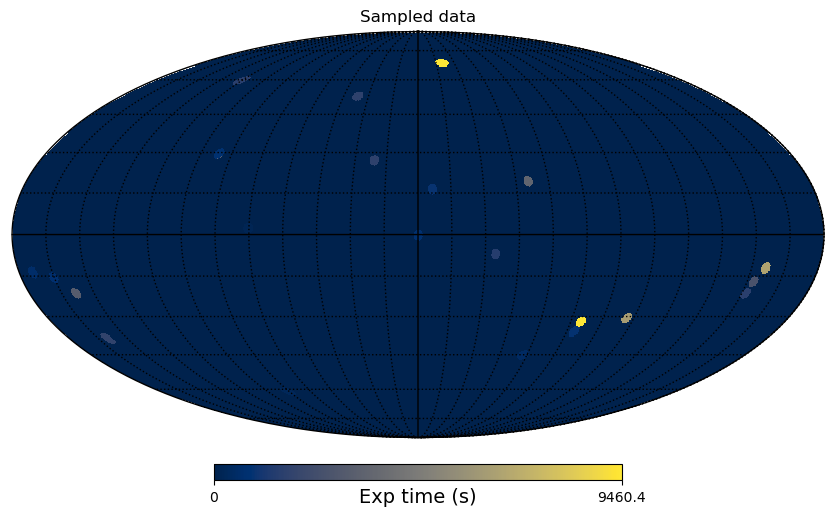

In [14]:
#Read data:
Ch1Arr, Ch2Arr, Ch3Arr, Ch4Arr, exptArr, longArr, latArr = readFitsDir("../raw_data/MRS_156",skymap=True,defr=False,sysError=0.1)

## Samples

In [108]:
#0th HDU: Info of data (including calibration)
#1st HDU: Data
#2nd HDU: Additional info of data
folderName = 'jw01192-o001_t011_miri'
#fitsFile = "../raw_data/MRS_all_data/"+folderName+"/x1d_ch1.fits"
fitsFile = "../raw_data/MRS_20/"+folderName+"/"+folderName+"_ch2-shortmediumlong_x1d.fits"
sub = fits.open(fitsFile)
print(sub.info())
print('###############################################################################')
print(sub[1].header['SRCTYPE'])
print(sub[0].header['SRCTYAPT'])
print(sub[0].header['BKGDTARG'])
#print(sub[0].header['BKGSUB'])
print(sub[0].header['S_MRSMAT'])
#print(sub[0].header['S_BKDSUB'])
#print(sub[0].header['S_MSBSUB'])
print(sub[0].header['EFFEXPTM'])
print(sub[0].header['ASNPOOL'])
print('###############################################################################')
print(sub[0].header)
# # from stdatamodels.jwst.datamodels import ImageModel
# # model = ImageModel(fitsFile)
# # model.data
# import stdatamodels.asdf_in_fits as asdfInFits
# af = asdfInFits.open(fitsFile)
# print(af.tree['meta'])

Filename: ../raw_data/MRS_20/jw01192-o001_t011_miri/jw01192-o001_t011_miri_ch2-shortmediumlong_x1d.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     376   ()      
  1  EXTRACT1D     1 BinTableHDU     69   3224R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  2  ASDF          1 BinTableHDU     11   1R x 1C   [64516B]   
None
###############################################################################
EXTENDED
UNKNOWN
False
SKIPPED
2197.8
jw01192_20240903t100235_pool.csv
###############################################################################
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  DATE    = '2024-09-03T13:19:12.591' / UTC date fi

Channel 1:
Wavelength range: (4.900400095357327, 7.650000025896588)
Array shape: (3438,)
Bin size (dlmd): 0.0007999999797903001
Channel 2:
Wavelength range: (7.5106502288836055, 11.700550240289886)
Array shape: (3224,)
Bin size (dlmd): 0.0013000000035390258
Channel 3:
Wavelength range: (11.551250190706924, 17.978750047041103)
Array shape: (2572,)
Bin size (dlmd): 0.0024999999441206455
Channel 4:
Wavelength range: (17.70300076296553, 28.70100085856393)
Array shape: (1834,)
Bin size (dlmd): 0.006000000052154064


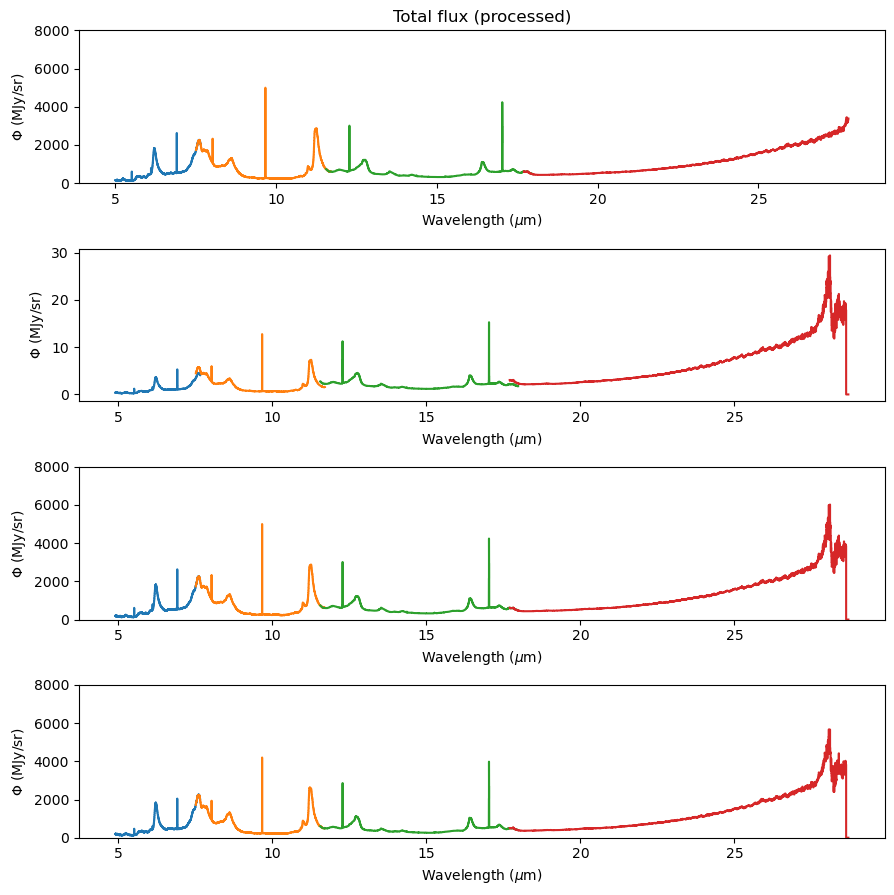

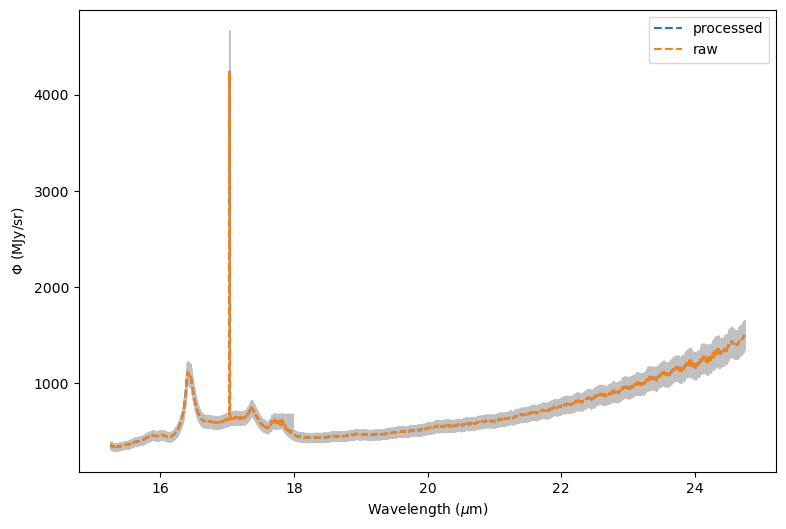

In [109]:
readFits('../raw_data/MRS_20/'+folderName,
        defringe=False,
        sysErr=0.1,
        M1=15.25,M2=24.75
)

# Stack spectra

In [7]:
stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4, SNR, exptime = stackSpectra(Ch1Arr,Ch2Arr,Ch3Arr,Ch4Arr,exptArr,defr=False)

Estimated log-signal-to-noise ratio:
[ 9.50910981 13.34035534 15.19897609 10.19515095 10.22853564 10.2999132
 10.34984985 10.38258377 10.43408435 11.91950936 11.94462805 12.13570595
 12.31743704 12.33424929 12.35368206 12.36175276 12.37680867 12.60503822
 12.63966914 12.66296048 12.75730819 13.28897282 13.33055808 13.39803252
 13.4154311  13.47544619 13.59489706 13.76942127 13.78796806 13.92356929
 12.41360866 12.4171442  12.41949824 12.44147945 12.44497913 12.44497913
 12.53037309 12.58014766 12.97970345 14.49379171 14.49649534 14.59912802
 14.62418    14.63016105 14.63310398 14.75283442 15.15242586 15.17230683
 15.17399377 15.17399377 15.20040044 15.2034154  15.20899872 15.22139975
 15.23507339 15.24308509 15.24467803 15.25500629 15.28684338 15.56727115
 15.56936466 15.6581708  15.66294997 16.05887313 16.15239373 16.15606272
 16.15945175 16.16138178 16.1645782  16.16755677 16.16990548 16.4760313
 16.47720767 16.47938502 16.48523892 16.61981445 16.65101919 16.65406985
 16.66423485 16.

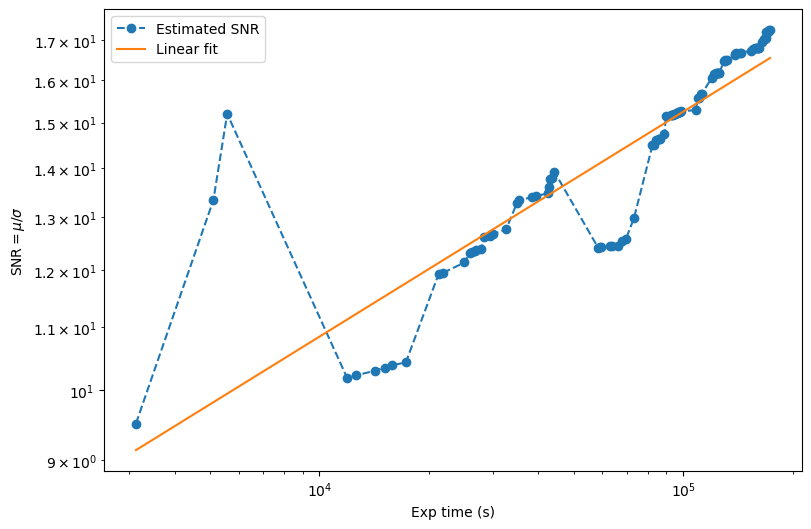

In [8]:
print('Estimated log-signal-to-noise ratio:')
print(SNR)
plt.figure(figsize=(9,6))
plt.plot(exptime,SNR,'--o',label='Estimated SNR')
plt.plot()
plt.ylabel('SNR$=\\mu/\\sigma$')
plt.xlabel('Exp time (s)')
plt.xscale('log')
plt.yscale('log')
#linear regression
p, lsq = linReg(np.log10(exptime),np.log10(SNR))
print(p)
plt.plot(exptime,10**p[1]*exptime**p[0],'-',label='Linear fit')
plt.legend()

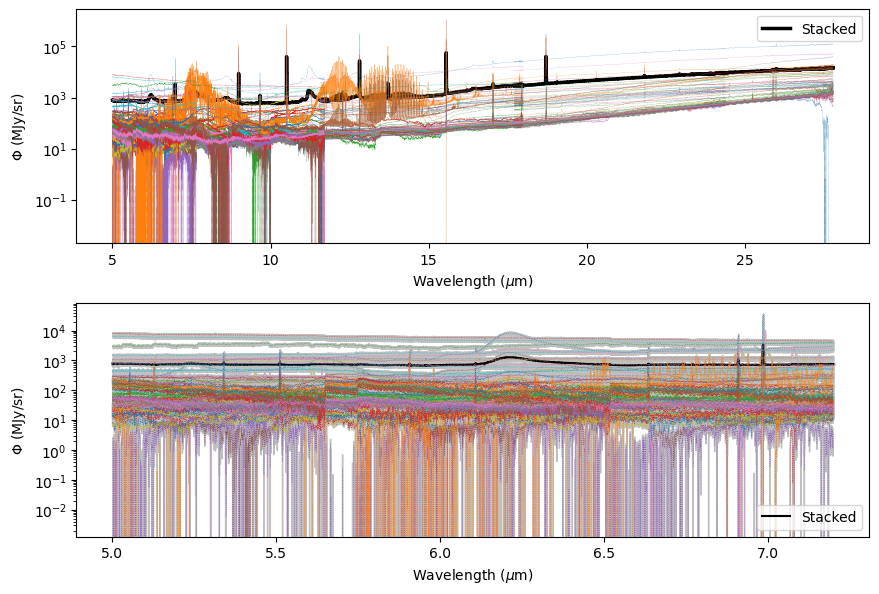

In [9]:
#Preview:
previewSpec(stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4, M1=5, M2=7.2, Ch1Arr=Ch1Arr, Ch2Arr=Ch2Arr, Ch3Arr=Ch3Arr, Ch4Arr=Ch4Arr)

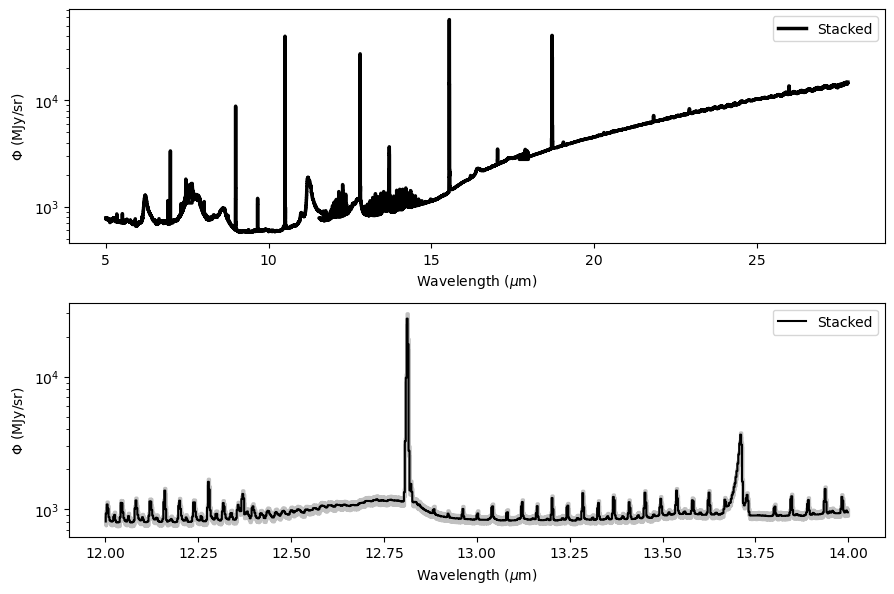

In [10]:
previewSpec(stkdata_ch1, stkdata_ch2, stkdata_ch3, stkdata_ch4, M1=12, M2=14)

In [ ]:
#Output array files:
np.savez('stkData.npz', ch1=stkdata_ch1, ch2=stkdata_ch2, ch3=stkdata_ch3, ch4=stkdata_ch4)
np.savez('metaData.npz', expt=exptArr, l=longArr, b=latArr)

# Testing

In [ ]:
import scipy.constants as constants
print(constant

* Really small SNR + wrong powerf
* undefined error in ch4

In [ ]:
a = np.array(['apple', 'orange', 'apple','orange'])

In [ ]:
dupl_rbespal(a)['apple']